In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np 
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score
from datetime import datetime, timedelta


from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.pipeline import Pipeline as imbpipeline

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import warnings
warnings.filterwarnings("ignore")


#### load the dataset.

In [4]:
as24_data_root = "drive/MyDrive/Interview Tasks/Autoscout24_task/"
auto_data = pd.read_csv(as24_data_root + "AS24_Case_Study_Data.csv",sep = ";")
auto_data.head()

,article_id,product_tier,make_name,price,first_zip_digit,first_registration_year,created_date,deleted_date,search_views,detail_views,stock_days,ctr
0,350625839,Basic,Mitsubishi,16750,5,2013,24.07.18,24.08.18,3091.0,123.0,30,0.03780329990294403
1,354412280,Basic,Mercedes-Benz,35950,4,2015,16.08.18,07.10.18,3283.0,223.0,52,0.06792567773378008
2,349572992,Basic,Mercedes-Benz,11950,3,1998,16.07.18,05.09.18,3247.0,265.0,51,0.0816137973514013
3,350266763,Basic,Ford,1750,6,2003,20.07.18,29.10.18,1856.0,26.0,101,0.014008620689655173
4,355688985,Basic,Mercedes-Benz,26500,3,2014,28.08.18,08.09.18,490.0,20.0,12,0.04081632653061224


#### varify the datatypes of the columns

In [5]:
auto_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78321 entries, 0 to 78320
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   article_id               78321 non-null  int64  
 1   product_tier             78321 non-null  object 
 2   make_name                78321 non-null  object 
 3   price                    78321 non-null  int64  
 4   first_zip_digit          78321 non-null  int64  
 5   first_registration_year  78321 non-null  int64  
 6   created_date             78321 non-null  object 
 7   deleted_date             78321 non-null  object 
 8   search_views             78311 non-null  float64
 9   detail_views             78311 non-null  float64
 10  stock_days               78321 non-null  int64  
 11  ctr                      78297 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 7.2+ MB


#### Convert the features to the relevant datatypes. 

In [6]:
auto_data["ctr"] = pd.to_numeric(auto_data["ctr"], errors = "coerce")
auto_data["created_date"] = pd.to_datetime(auto_data["created_date"])
auto_data["deleted_date"] = pd.to_datetime(auto_data["deleted_date"])

#### Encode the categorical variables. 
###### Ideally this should be a one hot enoder,but the usage of SMOTE makes it computationally expensive. However, we use the onehot encodings in the deep learning approach we see later in this notebook. 

In [7]:
tier_enc = LabelEncoder()
auto_data["product_tier_enc"] = tier_enc.fit_transform(auto_data["product_tier"])
name_enc = LabelEncoder() 
auto_data["make_name_enc"] = name_enc.fit_transform(auto_data["make_name"])

#### Compute the basic statistical properties  of the dataset. (Ignore the stats of categorical variable "make_name_enc")

In [8]:
auto_data.describe()

,article_id,price,first_zip_digit,first_registration_year,search_views,detail_views,stock_days,ctr,product_tier_enc,make_name_enc
count,7.832100e+04,78321.000000,78321.000000,78321.000000,78311.000000,78311.000000,78321.000000,78215.000000,78321.000000,78321.000000
mean,3.574869e+08,15067.655316,4.632117,2011.089465,2297.502522,93.469870,35.986262,0.047920,0.066700,57.727059
std,5.076572e+06,16374.497606,2.354275,6.538395,6339.034423,228.025588,32.214835,0.327363,0.348709,26.387424
min,3.472324e+08,1.000000,1.000000,1924.000000,0.000000,0.000000,-3.000000,0.000000,0.000000,0.000000
25%,3.536387e+08,5750.000000,3.000000,2008.000000,367.000000,13.000000,10.000000,0.024094,0.000000,33.000000
50%,3.585480e+08,10900.000000,5.000000,2013.000000,920.000000,36.000000,25.000000,0.037923,0.000000,67.000000
75%,3.614817e+08,18890.000000,7.000000,2015.000000,2234.000000,94.000000,55.000000,0.058201,0.000000,78.000000
max,3.647040e+08,249888.000000,9.000000,2106.000000,608754.000000,13926.000000,127.000000,87.500000,2.000000,90.000000


##### Check for the missing values in the dataset.

In [9]:
auto_data.isnull().sum()

article_id                   0
product_tier                 0
make_name                    0
price                        0
first_zip_digit              0
first_registration_year      0
created_date                 0
deleted_date                 0
search_views                10
detail_views                10
stock_days                   0
ctr                        106
product_tier_enc             0
make_name_enc                0
dtype: int64

### Compute the distribution of target variable. 
#### The plot shows the fraction of each class contribution. The Product tier "Basic" is the label for over 96% of the datapoints indicating a significant class imbalance in the dataset. 

<BarContainer object of 3 artists>

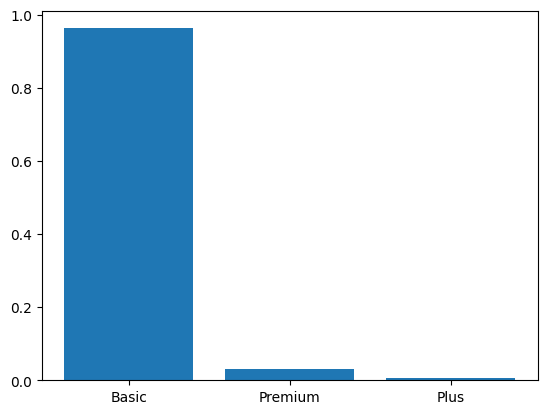

In [10]:
value_counts = auto_data["product_tier"].value_counts() / len(auto_data)
plt.bar(value_counts.index, value_counts.values)

#### Heatmap to understand the correlation between different PAIRS of features,and the correlation of differet features with the ground truth.
##### Again, the correlation of the categorical variable should be ignored here. 

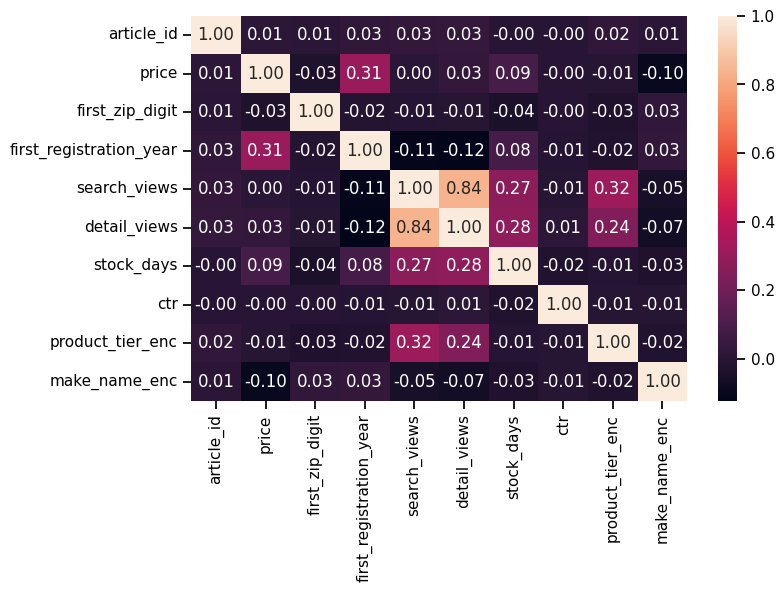

In [11]:
corr = auto_data.corr()
sns.set_context("notebook", font_scale=1.0, rc={"lines.linewidth": 2.5})
plt.figure(figsize=(8,5))
a = sns.heatmap(corr, annot=True, fmt='.2f')
rotx = a.set_xticklabels(a.get_xticklabels())
roty = a.set_yticklabels(a.get_yticklabels())

#### Removing the datapints with ctr>1

In [12]:
print("number of datapoints with ctr > 1 : ", (auto_data["ctr"]>1).sum())
auto_data = auto_data[auto_data["ctr"]<=1]

number of datapoints with ctr > 1 :  2


#### Varifying the correlation between price and product tier

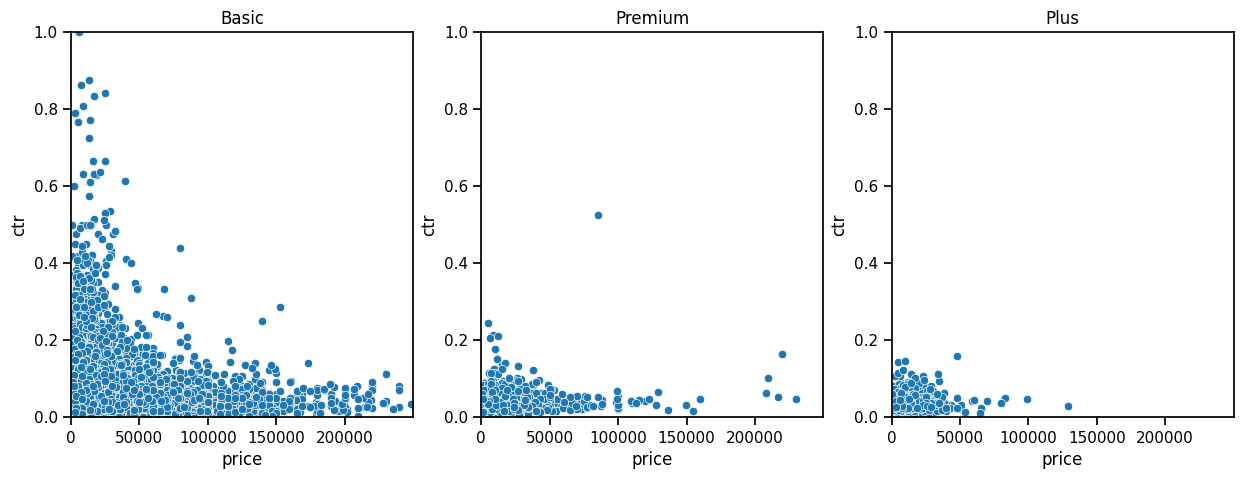

In [13]:
fig, ax =plt.subplots(nrows = 1, ncols = 3, figsize= (15,5))
max_ctr = 1
max_price = max(auto_data["price"])
for i,tier in enumerate(["Basic","Premium","Plus"]):
    sns.scatterplot(data = auto_data[auto_data["product_tier"] == tier], x = "price", y =  "ctr",ax = ax[i])
    ax[i].set_title(tier)
    ax[i].set_xlim(0,max_price)
    ax[i].set_ylim(0,max_ctr)

#### Distribution of price for different product tiers. 

<Axes: xlabel='product_tier_enc', ylabel='price'>

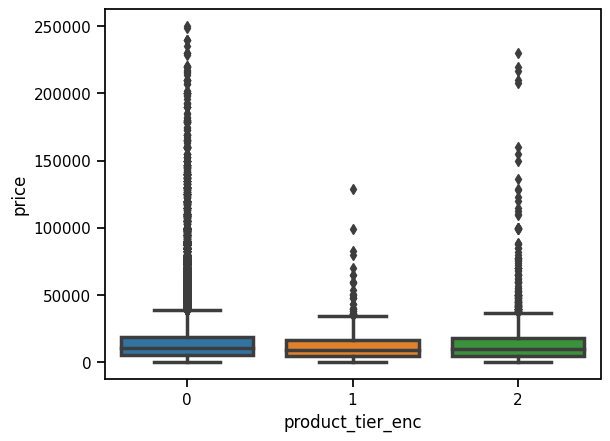

In [14]:
sns.boxplot(x="product_tier_enc", y="price", data=auto_data)

In [15]:
auto_data = auto_data.fillna(auto_data.mean())

#### Remove anomolous entry, clearly first registration in 2050 is a corrupted entry. 

In [16]:

print("latest first registration: ",max(auto_data["first_registration_year"]))
auto_data = auto_data[auto_data["first_registration_year"]< 2025]

latest first registration:  2106


#### Visualizing correlation between price and first registration year in different product tiers.

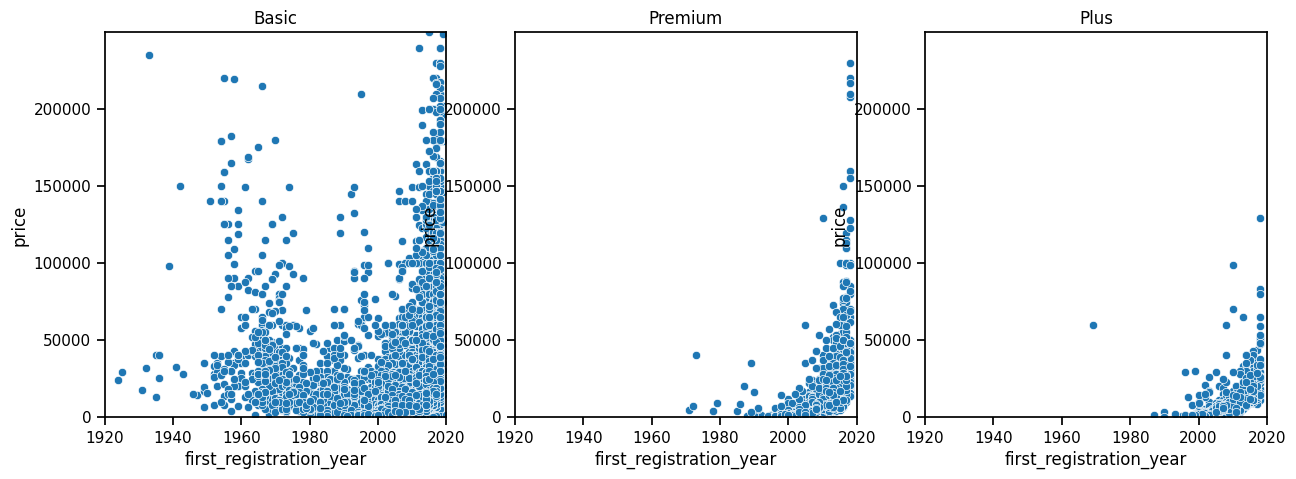

In [17]:
fig, ax =plt.subplots(nrows = 1, ncols = 3, figsize= (15,5))
max_year = max(auto_data["first_registration_year"])
max_price = max(auto_data["price"])
for i,tier in enumerate(["Basic","Premium","Plus"]):
    sns.scatterplot(data = auto_data[auto_data["product_tier"] == tier], x = "first_registration_year", y =  "price",ax = ax[i])
    ax[i].set_title(tier)
    ax[i].set_ylim(0,max_price)
    ax[i].set_xlim(1920,max_year)

#### Visualizing the correlation between search views and detail views for different product tiers

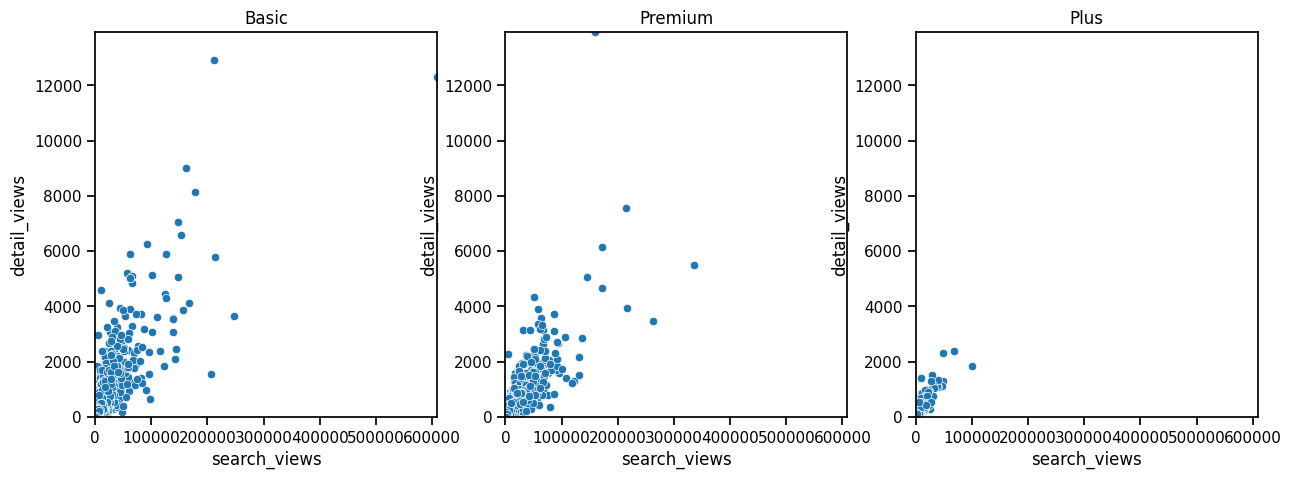

In [18]:
fig, ax =plt.subplots(nrows = 1, ncols = 3, figsize= (15,5))
max_search = max(auto_data["search_views"])
max_details = max(auto_data["detail_views"])
for i,tier in enumerate(["Basic","Premium","Plus"]):
    sns.scatterplot(data = auto_data[auto_data["product_tier"] == tier], y = "detail_views", x =  "search_views",ax = ax[i])
    ax[i].set_title(tier)
    ax[i].set_xlim(0,max_search)
    ax[i].set_ylim(0,max_details)

#### Distribution of creation dates, correlation between detail_views and creation dates.

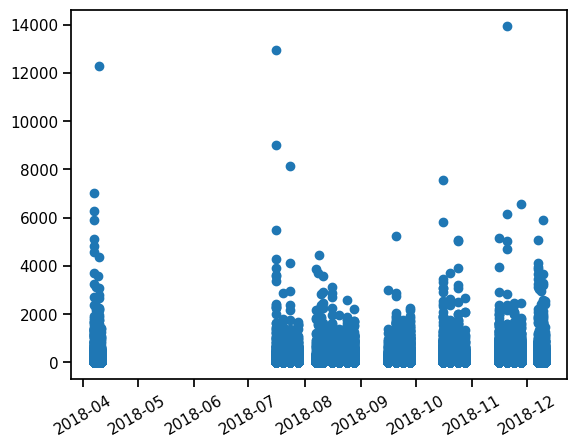

In [19]:
sam_data = auto_data#[auto_data["created_date"].dt.month == 8]
plt.scatter(sam_data["created_date"], sam_data["detail_views"])
plt.xticks(rotation = 30)
plt.show()

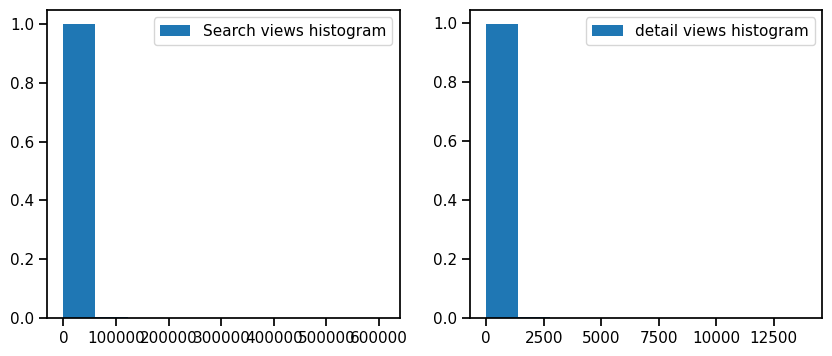

In [20]:
fig,ax = plt.subplots(nrows =1, ncols = 2, figsize= (10,4))
ax[0].hist(auto_data["search_views"],weights=np.ones(len(auto_data)) / len(auto_data),label = "Search views histogram")
ax[1].hist(auto_data["detail_views"],weights=np.ones(len(auto_data)) / len(auto_data), label = "detail views histogram")
ax[0].legend()
ax[1].legend()

#### Drop the unnecessary features from the dataset, perform starified split on  data to  maintain the same label distribution in train and test datasets. 


In [21]:
X = auto_data.drop(["article_id","product_tier","make_name",
                    "product_tier_enc","created_date","deleted_date",],axis = 1)
y = auto_data["product_tier_enc"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11,stratify = y)
#extract continues column names, to exclude them from normalization
cont_cols = X.columns.drop(["make_name_enc"])

#### Define scaler to normalize only the continues variables and leave out the categorical variables.

In [22]:

ContScaler =  ColumnTransformer(
        transformers=[
            ('continuous', StandardScaler(), cont_cols)  # Normalize continuous features
            ],
            remainder='passthrough'  # Pass through the categorical features without any transformation
        )

#### A baseline logistic regression model with balanced class weight to handle class imbalance. Grid search is used with stratified Kfold cross validation for finetuning the model. 

In [23]:
%%time
pipeline = Pipeline(steps = [['preprocessor', ContScaler],
                             ['classifier', LogisticRegression(random_state=11,
                                                               max_iter=200, class_weight='balanced')]])

stratified_kfold = StratifiedKFold(n_splits=5,
                                       shuffle=True,
                                       random_state=11)
    
param_grid = {'classifier__C':[0.1, 1, 10]}
grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           scoring='f1_macro',
                           cv=stratified_kfold,
                           n_jobs=-1)
grid_search.fit(X_train, y_train)
cv_score = grid_search.best_score_
test_score = grid_search.score(X_test, y_test)
y_pred = grid_search.predict(X_test)
print("Best cross validation f1 score: ", round(cv_score,3))
print("Best test f1 score: ", round(test_score,3))
print(classification_report(y_test, y_pred, target_names = tier_enc.classes_))

Best cross validation f1 score:  0.476
Best test f1 score:  0.478
              precision    recall  f1-score   support

       Basic       0.99      0.87      0.93     15064
        Plus       0.03      0.40      0.06       115
     Premium       0.35      0.63      0.45       464

    accuracy                           0.86     15643
   macro avg       0.46      0.63      0.48     15643
weighted avg       0.97      0.86      0.91     15643

CPU times: user 4.22 s, sys: 2.45 s, total: 6.66 s
Wall time: 37.5 s


#### If we look at just the accuracy score it is very missleading. Especially because of the class imbalance in the dataset, we should be looking at the precision and recall of individual classes.  


In [24]:
pipeline

Pipeline(steps=[['preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('continuous',
                                                  StandardScaler(),
                                                  Index(['price', 'first_zip_digit', 'first_registration_year', 'search_views',
       'detail_views', 'stock_days', 'ctr'],
      dtype='object'))])],
                ['classifier',
                 LogisticRegression(class_weight='balanced', max_iter=200,
                                    random_state=11)]])

#### summarize feature importance
#### plot feature importance

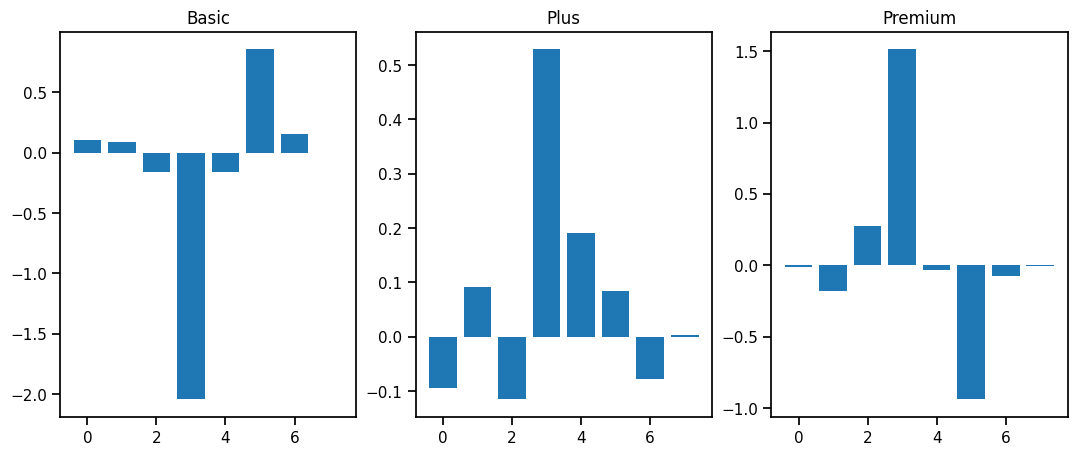

In [25]:
clf = grid_search.best_estimator_.named_steps['classifier']
fig,ax = plt.subplots(nrows = 1, ncols = 3,figsize = (13,5))
for i,importance in enumerate(clf.coef_):
    ax[i].bar([x for x in range(len(importance))], importance)
    ax[i].set_title(tier_enc.classes_[i])

### Using SMOTE (Synthetic Minority Oversampling Technique) to handle the imbalanced data by generating mode minority samples. 
#### The order of the steps in is very crucial here. Please refer the here for [details](https://towardsdatascience.com/the-right-way-of-using-smote-with-cross-validation-92a8d09d00c7).  

###### Note: The feature "ctr" is computed by taking ratio of two features. Ideally while over sampling we should, leave this feature out and compute it after over sampling. Here we have generated the feature values for ctr as well for simplicity.  

In [26]:

def train_test_smote(X_train, y_train,X_test, y_test, model, param_grid):
    pipeline = imbpipeline(steps =[
                                # ['nearmiss', NearMiss(version=3, n_neighbors=3)],
                                ['smote', SMOTE(random_state=11)],
                                ['preprocessor',ContScaler],
                                ['model', model]
                                ])

    stratified_kfold = StratifiedKFold(n_splits=3,
                                        shuffle=True,
                                        random_state=11)
    
    grid_search = GridSearchCV(estimator=pipeline,
                            param_grid=param_grid,
                            scoring='f1_macro',
                            cv=stratified_kfold,
                            n_jobs=-1)
    
    grid_search.fit(X_train, y_train)
    cv_score = grid_search.best_score_
    test_score = grid_search.score(X_test, y_test)
    y_pred = grid_search.predict(X_test)
    print("Best cross validation f1 score: ", round(cv_score,3))
    print("Best test f1 score: ", round(test_score,3))
    print(classification_report(y_test, y_pred, target_names = tier_enc.classes_))
    return grid_search.best_estimator_

In [27]:
%%time
lr_model = LogisticRegression(random_state=11, max_iter=200, class_weight='balanced')
lr_param_grid = {'model__C':[0.1, 1, 10]}
pipeline = train_test_smote(X_train, y_train,X_test, y_test,lr_model,lr_param_grid)

Best cross validation f1 score:  0.421
Best test f1 score:  0.413
              precision    recall  f1-score   support

       Basic       0.99      0.82      0.89     15064
        Plus       0.03      0.43      0.06       115
     Premium       0.19      0.64      0.29       464

    accuracy                           0.81     15643
   macro avg       0.40      0.63      0.41     15643
weighted avg       0.96      0.81      0.87     15643

CPU times: user 10.3 s, sys: 6.08 s, total: 16.4 s
Wall time: 52.6 s


#### Model with the Random Forest classifier. 

In [28]:
%%time
rf_model = RandomForestClassifier(random_state=11,class_weight='balanced')
rf_param_grid = { 
    'model__n_estimators': [100,200],
    # 'model__max_features': ['auto', 'sqrt', 'log2'],
    # 'model__max_depth' : [4,8,12,16],
    # 'model__criterion' :['gini', ']
}
# uncomment the below lines for more exhaustive grid search

# rf_param_grid = { 
#     'model__n_estimators': [200, 500],
#     'model__max_features': ['auto', 'sqrt', 'log2'],
#     'model__max_depth' : [4,8,12,16],
#     'model__criterion' :['gini', 'entropy']
# }
pipeline = train_test_smote(X_train, y_train,X_test, y_test,rf_model,rf_param_grid)

Best cross validation f1 score:  0.534
Best test f1 score:  0.548
              precision    recall  f1-score   support

       Basic       0.99      0.96      0.98     15064
        Plus       0.08      0.14      0.10       115
     Premium       0.46      0.74      0.57       464

    accuracy                           0.95     15643
   macro avg       0.51      0.61      0.55     15643
weighted avg       0.97      0.95      0.96     15643

CPU times: user 1min 39s, sys: 464 ms, total: 1min 39s
Wall time: 6min 9s


#### Age of the car can be relevant feature, as it describes the difference between the year of first registration and the year of selling order creation.


In [29]:
auto_data["age"] = auto_data["created_date"].dt.year - auto_data["first_registration_year"]

In [30]:
print("Different ad creation years :", np.unique(auto_data["created_date"].dt.year))
print("Different ad deleted years :", np.unique(auto_data["deleted_date"].dt.year))

Different ad creation years : [2018]
Different ad deleted years : [2018 2019]


#### Compute the feature "price_age" as the ratio of age of the automobile to it's price

In [31]:
auto_data["price_age"] = auto_data["age"] / auto_data["price"]

#### Compute the feature price_ratio as the ratio of price of the automobile to the mean price of the particular product tier. 

In [32]:
auto_data["views_diff"]= auto_data["search_views"]- auto_data["detail_views"]
mean_tier_price = auto_data.groupby("product_tier").mean("price")["price"]
auto_data["price_ratio"] = auto_data["price"] / mean_tier_price[auto_data["product_tier"]].values


#### Get one hot encding for the categorical variable.

In [33]:
auto_data = pd.get_dummies(auto_data, columns = ["make_name"])

#### Similar to earlier, remove unnecessary features, split the data for training and testing. Normalize the continues data. 

In [34]:
# Remove unnecessary features 
X = auto_data.drop(["article_id","product_tier","make_name_enc",
                    "product_tier_enc","created_date","deleted_date","age", "views_diff","price_age","price_ratio"],axis = 1)
y = auto_data["product_tier_enc"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11,stratify = y)
# cont_cols = X.columns.drop(["make_name_enc"])
cont_cols = X.columns[~pd.Series(X.columns).str.startswith("make_name")]
# Normalize the continues data. 
scaler = StandardScaler()
X_train[cont_cols] = scaler.fit_transform(X_train[cont_cols])
X_test[cont_cols] = scaler.transform(X_test[cont_cols])

### In the Below sections, we will try to model the data with a deep learning approach by a simple ANN. 

#### Define the custom dataset class that implements the __init__, __len__, __getitem__ functions. Compute class weights by the number datapoints in each class.

In [35]:
X_train = torch.Tensor(X_train.values)
y_train = torch.Tensor(y_train.values).long()
X_test = torch.Tensor(X_test.values)
y_test = torch.Tensor(y_test.values).long()

# Define a custom dataset class
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.y[index]

# Create instances of the custom dataset class
train_dataset = CustomDataset(X_train, y_train)
test_dataset = CustomDataset(X_test, y_test)

# Define the class weights
class_counts = np.bincount(y_train)
num_classes = len(class_counts)
class_weights = 1.0 / torch.Tensor(class_counts)

#### Define a simple ANN with an input and output layer along with one hidden layer. 

In [36]:
# Define the ANN model
class TierModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(TierModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size // 2)
        self.bn2 = nn.BatchNorm1d( hidden_size // 2)
        self.fc3 = nn.Linear(hidden_size//2, output_size)
    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

#### Common loop function for train and test loop.

In [37]:
def TrainTestLoop(data_loader,model,optimizer,criterion,scheduler, mode= "train",):
    ''' Common loop function for train and test loop. 
    '''
    epoch_loss = 0
    f1_val = 0
    y_pred = []
    y_test = []
    report = None
    if(mode == "train"):
        model.train()
    else:
        model.eval()
    
    for inputs, labels in data_loader:
        # Forward pass
        outputs = model(inputs)
        optimizer.zero_grad()
        loss = criterion(outputs, labels)
        if(mode == "train"):
            # Backward and optimize
            loss.backward()
            optimizer.step()
            
        _, predicted = torch.max(outputs.data, 1)
        epoch_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        f1_val += f1_score(labels, predicted, average = "macro")
        if(mode == "test"):
            y_pred.extend(predicted.tolist())
            y_test.extend(labels.tolist())

    scheduler.step() #Update the learning rate after the epoch

    average_f1 = f1_score(y_test, y_pred, average = "macro")
    average_loss = epoch_loss / len(data_loader)
    if(mode == "test"):
        report = classification_report(y_test, y_pred)
    return average_loss, average_f1, report

In [38]:
%%time
input_size = X.shape[1]
hidden_size = 16
output_size = num_classes
torch.manual_seed(0) #Fix the random generator for replication
# Create an instance of the model
model = TierModel(input_size, hidden_size, output_size)

# Define the loss function with class weights
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Define the optimizer
weight_decay = 1e-4
optimizer = optim.Adam(model.parameters(), lr=0.0001,weight_decay = weight_decay)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.75) # ExponentialLR to adjust the lr, lr_(t+1) = lr_(t) * gamma

# Create dataloaders for efficient data handling, batch processing.
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Train the model
num_epochs = 14
for epoch in range(num_epochs):
    loss, f1,_ = TrainTestLoop(train_loader,model, optimizer, criterion,scheduler)
    test_loss, test_f1,report = TrainTestLoop(test_loader,model, optimizer, criterion,scheduler, mode= "test")
    print("Epoch: {}, train loss: {},test loss: {}, test f1_score: {}".format(epoch,round(loss,3), round(test_loss,3), round(test_f1,3)))

Epoch: 0, train loss: 1.014,test loss: 0.958, test f1_score: 0.442
Epoch: 1, train loss: 0.872,test loss: 0.856, test f1_score: 0.446
Epoch: 2, train loss: 0.823,test loss: 0.831, test f1_score: 0.456
Epoch: 3, train loss: 0.799,test loss: 0.815, test f1_score: 0.444
Epoch: 4, train loss: 0.783,test loss: 0.808, test f1_score: 0.438
Epoch: 5, train loss: 0.78,test loss: 0.802, test f1_score: 0.442
Epoch: 6, train loss: 0.773,test loss: 0.825, test f1_score: 0.485
Epoch: 7, train loss: 0.773,test loss: 0.798, test f1_score: 0.454
Epoch: 8, train loss: 0.773,test loss: 0.797, test f1_score: 0.461
Epoch: 9, train loss: 0.77,test loss: 0.835, test f1_score: 0.485
Epoch: 10, train loss: 0.769,test loss: 0.798, test f1_score: 0.46
Epoch: 11, train loss: 0.769,test loss: 0.802, test f1_score: 0.456
Epoch: 12, train loss: 0.767,test loss: 0.815, test f1_score: 0.475
Epoch: 13, train loss: 0.771,test loss: 0.809, test f1_score: 0.471
CPU times: user 2min 15s, sys: 335 ms, total: 2min 15s
Wall t

In [39]:
print(report)

              precision    recall  f1-score   support

           0       0.98      0.96      0.97     15064
           1       0.00      0.00      0.00       115
           2       0.33      0.67      0.44       464

    accuracy                           0.94     15643
   macro avg       0.44      0.54      0.47     15643
weighted avg       0.96      0.94      0.95     15643

